In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
# Модуль для построения нейросетей
import torch.nn as nn
# Все, что связано с функциями (функции потерь, активации и пр.)
import torch.nn.functional as F
# Оптимизаторы из торча достаем
import torch.optim as optim
# DataLoader позволяет загружать данные из Dataset и имеет различные функции (Shuffle, Batching, Multiprocessing)
from torch.utils.data import DataLoader, Dataset

# Красивый прогресс-бар
from tqdm.notebook import tqdm

# classification_report - сводная таблица со всеми метриками
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Очистка результата выполнения функции display  и отрисовки только актуального значения
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Установка общего стиля графиков seaborn
sns.set_theme()

# 0. Обеспечение воспроизводимости

In [2]:
# Устанавливаем random_seed там, где это только возможно
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# 1. Загрузка датасета

In [3]:
df = pd.read_csv('air_quality.csv')
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,air_quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,1
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,1
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,1
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,1
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,1


# 2. Подготовка данных

## 2.1 Разделение на TVT

In [4]:
# В датафрейме X убираем целевую переменную, y - наша целевая переменная
X, y = df.drop('air_quality', axis=1), df['air_quality']
# Делим исходный датасет на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# И уже далее формируем валидационную выборку из тестовой
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.25, random_state = 42)

## 2.2 Обертка данных

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # X - датафрейм, X.values - это просто массив всех значений, мы его превращаем в тензор
        self.X = torch.Tensor(X.values)
        # Для таргета немного по-другому, reshape(-1, 1) - минус один означает вот сколько там элементов, столькими строками и заполнить;
        # Один - значит одна колонка
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()
        
    def __len__(self):
        # Возвращаем количество строк
        return self.X.shape[0]
        
    def __getitem__(self, index):
        # Получаем композицию (признак + таргет)
        return (self.X[index], self.y[index])


In [6]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Shuffle = False для обеспечения воспроизводимости
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Реализация нейросети

In [8]:
class AirQualityNN(nn.Module):
    # num_labels - количество выходных нейронов, для данной задачи (0, 1)
    # input_size - количество входных нейронов, входных параметров
    # n_linear_layers - количество слоев нейросети
    # activation - функция активации
    
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.Sigmoid):
        
        # Надо не забыть вызвать конструктор базового класса, т.к. что-то может не проинициализироваться
        super(AirQualityNN, self).__init__()
        
        # Инициализация списка слоев, изначально просто первый слой добавляем (тут же и веса инициализируются равномерным распределением!!!)
        layers = [nn.Linear(input_size, hidden_size), activation()]
        
        # Далее - оставшиеся n-2 слоев, 
        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())
            
        # Последний слой
        layers.append(nn.Linear(hidden_size, num_labels))
        
        # Последовательный контейнер для хранений нейросети в PyTorch. Последовательно передается структура слоя, а потом функция активации
        self.layers = nn.Sequential(*layers)

    # x - вход для нейросети
    def forward(self, x):
        
        # На выходе (только на выходе!!!) преобразуем в [0, 1]
        y_pred = torch.sigmoid(self.layers(x))
        # Выдаем результаты прогноза нейросети 
        return y_pred
        

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Гиперпараметры

input_size = 9  # количество входных признаков (без таргета!)
hidden_size = 20 # количество нейронов на скрытом слое
num_labels = 1   # бинарный выход
n_linear_layers = 3 # количество слоев
activation = nn.ReLU  # активация
learning_rate = 0.01 # скорость обучения
num_epochs = 100
batch_size = 16

In [29]:
# Создаем модель с нашими параметрами
model = AirQualityNN(num_labels=num_labels, input_size=input_size, hidden_size=hidden_size, n_linear_layers=n_linear_layers, activation=activation)
# Помещаем в наш девайс
model = model.to(device)

In [30]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Определяем оптимизатор

# 4. Цикл обучения

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.7569, Val Loss: 0.2822
Epoch [2/100], Train Loss: 0.3236, Val Loss: 0.2721
Epoch [3/100], Train Loss: 0.2613, Val Loss: 0.1950
Epoch [4/100], Train Loss: 0.2523, Val Loss: 0.1879
Epoch [5/100], Train Loss: 0.2318, Val Loss: 0.3071
Epoch [6/100], Train Loss: 0.2154, Val Loss: 0.1673
Epoch [7/100], Train Loss: 0.2218, Val Loss: 0.1779
Epoch [8/100], Train Loss: 0.2251, Val Loss: 0.1636
Epoch [9/100], Train Loss: 0.2255, Val Loss: 0.1654
Epoch [10/100], Train Loss: 0.2058, Val Loss: 0.1816
Epoch [11/100], Train Loss: 0.1937, Val Loss: 0.1428
Epoch [12/100], Train Loss: 0.1924, Val Loss: 0.1551
Epoch [13/100], Train Loss: 0.1884, Val Loss: 0.1980
Epoch [14/100], Train Loss: 0.1861, Val Loss: 0.1753
Epoch [15/100], Train Loss: 0.1645, Val Loss: 0.1455
Epoch [16/100], Train Loss: 0.1744, Val Loss: 0.1372
Epoch [17/100], Train Loss: 0.1584, Val Loss: 0.2576
Epoch [18/100], Train Loss: 0.1778, Val Loss: 0.1202
Epoch [19/100], Train Loss: 0.1585, Val Loss: 0.1826
Ep

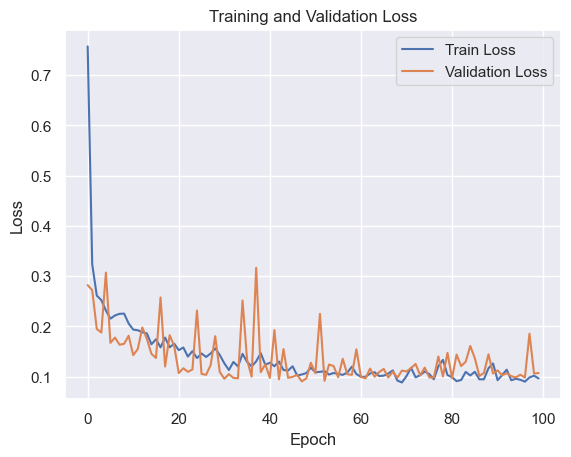

In [31]:
# Собираем наши лоссы для каждого шага
train_losses = []
val_losses = []

# Обучение (train-loop)
for epoch in tqdm(range(num_epochs)):
    # Переводим в режим обучения, см. подробнее: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # Считаем общий лосс, чтобы потом вычислять среднее
    running_train_loss = 0.0

    # Для признаков и таргетов
    for inputs, labels in train_dataloader:
        # Помещаем в наш девайс, это один батч у нас
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (т.е. наши данные проходят через модель (с текущими весами) и затем смотрим на лосс, как часто модель ошибалась)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        # Обнуляем градиенты, которые уже не актуальны
        optimizer.zero_grad()
        # Обратный проход по структуре
        loss.backward()
        # Обновление весов
        optimizer.step()
        # Суммируем лосс
        running_train_loss += loss.item()

    # Средняя функция потерь на тренировочной выборке за эпоху, чтобы не зависеть от аномалий всякого рода
    train_loss = running_train_loss / len(train_dataloader)
    # Добавляем тренировочный лосс
    train_losses.append(train_loss)

    # Валидация (eval-loop)
    # Переводим в режим оценивания
    model.eval()
    running_val_loss = 0.0
    # Отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Средняя функция потерь на валидационной выборке за эпоху
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 5. Проверка результатов

In [32]:
from sklearn.metrics import classification_report

# Тестирование модели
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Построение отчета о классификации
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       233
         1.0       0.99      0.98      0.98       517

    accuracy                           0.98       750
   macro avg       0.97      0.98      0.97       750
weighted avg       0.98      0.98      0.98       750

